# Setup

In [1]:
DATA_VERSION = "2025-06-30"
DATA_FILE_NAME = f"consultation-documents-preprocessed-{DATA_VERSION}.parquet"
EXTRA_DOCUMENT_FEATURES_FILE_NAME = f"consultation-documents-features-{DATA_VERSION}.parquet"
EMBEDDINGS_FILE_NAME = (
    f"consultation-documents-embeddings-beginnings-openai-text-embedding-3-large-{DATA_VERSION}.parquet"
)

LANGUAGES = {
    "de",
    # "fr",
    # "it",
}

FROM_YEAR = 2000

# Do not train nor test on documents from cantons that have known data quality issues.
EXCLUDE_POLITICAL_BODIES = {
    "bl",
    "ge",
    "ne",
    "sz",
    "vd",
    "vs",
}

INCLUDE_RULE_LABELS_IN_TRAINING = {
    # These are labels after class merging.
    "SYNOPTIC_TABLE",
    "LETTER",
    "RECIPIENT_LIST",
    "FINAL_REPORT",
    "SURVEY",
}

CV_FOLDS = 5
# This fraction only applies to manually labelled OpenParlData documents. Many more documents make it
# into the training set, e.g. all Fedlex documents.
TEST_SIZE = 0.15
RANDOM_STATE = 271828

RUN_HYPEROPTIMIZATION = False
HYPERPARAMETERS = {
    "classifier": {
        "type": "SVC",
        "C": 1.0,
        "class_weight": None,
        "gamma": "scale",
        "kernel": {"type": "rbf"},
    },
    "pca_n_components": 100,
}

assert RUN_HYPEROPTIMIZATION ^ bool(HYPERPARAMETERS)

In [2]:
%load_ext autoreload
%autoreload 2

import logging
import pathlib
import sys
from typing import Any

import dotenv
import hyperopt
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics
import sklearn.model_selection
import sklearn.pipeline
from hyperopt import pyll

REPOSITORY_ROOT = (pathlib.Path().cwd() / ".." / "..").resolve()
sys.path.append(str(REPOSITORY_ROOT))

/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/hyperopt/atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [3]:
import demokratis_ml.models.document_types.model
import demokratis_ml.models.document_types.preprocessing
from research.document_types import document_title_rule_model, training_split
from research.lib import data_access, plotting, utils

In [4]:
dotenv.load_dotenv()
utils.set_up_logging_and_mlflow("VM_document_type_classifier")

mlflow.log_param("data_version", DATA_VERSION)
mlflow.log_param("input_file", DATA_FILE_NAME)
mlflow.log_param("extra_features_file", EXTRA_DOCUMENT_FEATURES_FILE_NAME)
mlflow.log_param("embeddings_file", EMBEDDINGS_FILE_NAME)
mlflow.log_param("languages", LANGUAGES)
mlflow.log_param("from_year", FROM_YEAR)
mlflow.log_param("cv_folds", CV_FOLDS)
mlflow.log_param("test_size", TEST_SIZE)
mlflow.log_param("random_state", RANDOM_STATE)
mlflow.log_param("run_hyperoptimization", RUN_HYPEROPTIMIZATION)
mlflow.log_param("include_rule_labels_in_training", sorted(INCLUDE_RULE_LABELS_IN_TRAINING))
mlflow.log_param("exclude_political_bodies", sorted(EXCLUDE_POLITICAL_BODIES))
mlflow.log_param("merge_classes", demokratis_ml.models.document_types.preprocessing.MERGE_CLASSES)
;

INFO research.lib.utils: MLflow tracking to https://mlflow.ml1.demokratis.ch/
INFO research.lib.utils: Starting run = unequaled-grub-390


''

# Input data preparation

## Get all dataframes

In [7]:
PREPROCESSED_DATA_FILE = REPOSITORY_ROOT / "data" / "dataframes" / DATA_FILE_NAME
data_access.ensure_dataframe_is_available(PREPROCESSED_DATA_FILE)

FEATURES_DATA_FILE = REPOSITORY_ROOT / "data" / "dataframes" / EXTRA_DOCUMENT_FEATURES_FILE_NAME
data_access.ensure_dataframe_is_available(FEATURES_DATA_FILE)

EMBEDDINGS_DATA_FILE = REPOSITORY_ROOT / "data" / "dataframes" / EMBEDDINGS_FILE_NAME
data_access.ensure_dataframe_is_available(EMBEDDINGS_DATA_FILE)

INFO download_file_from_exoscale: Downloading dataframes/consultation-documents-preprocessed-2025-06-30.parquet from bucket demokratis-ml to /Users/vita/Code/demokratis/demokratis-ml/data/dataframes/consultation-documents-preprocessed-2025-06-30.parquet
INFO download_file_from_exoscale: Downloading dataframes/consultation-documents-features-2025-06-30.parquet from bucket demokratis-ml to /Users/vita/Code/demokratis/demokratis-ml/data/dataframes/consultation-documents-features-2025-06-30.parquet
INFO download_file_from_exoscale: Downloading dataframes/consultation-documents-embeddings-beginnings-openai-text-embedding-3-large-2025-06-30.parquet from bucket demokratis-ml to /Users/vita/Code/demokratis/demokratis-ml/data/dataframes/consultation-documents-embeddings-beginnings-openai-text-embedding-3-large-2025-06-30.parquet


In [8]:
df_docs = data_access.load_consultation_documents(
    PREPROCESSED_DATA_FILE, only_languages=LANGUAGES, starting_year=FROM_YEAR
)
df_docs

,document_id,document_uuid,consultation_id,consultation_identifier,consultation_start_date,consultation_end_date,consultation_title,consultation_description,document_source_url,consultation_url,...,organisation_name,political_body,latest_stored_file_id,document_source,consultation_topics_label_source,document_type_label_source,document_content_plain,stored_file_path,stored_file_mime_type,stored_file_hash
0,1,1CAJoURQMxKeqCdQ4jLniS,1,7bt3hz2w,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,...,Bundesamt für Zoll und Grenzsicherheit,ch,7780,fedlex,manual,fedlex,«$$e-seal» \n«$$QrCode» \n \n2021-… \n«%ASFF_Y...,2024/1/1/1CM3wffPbDu7fUxY1BS22e.pdf,application/pdf,b8816738ad84d806e55723a313613097bed2752f
3,4,1CAJoURQMxKeqCdQ4vhCQx,1,7bt3hz2w,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,...,Bundesamt für Zoll und Grenzsicherheit,ch,7783,fedlex,manual,fedlex,Eidgenössisches Finanzdepartement EFD \nEidgen...,2024/1/4/1CM3wfhvda7QqrdPBrFGXj.pdf,application/pdf,d47bb05bc7f135a0b850702336ecca328f7dafce
6,7,1CAJoURQMxKeqCdQ564eYH,1,7bt3hz2w,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,...,Bundesamt für Zoll und Grenzsicherheit,ch,7786,fedlex,manual,fedlex,Eidgenössisches Finanzdepartement EFD \nEidgen...,2024/1/7/1CM3wfjqyn9SRWiSzYWSf3.pdf,application/pdf,fdcb391ccf2efd9b56a446e39284e3cceab5e4eb
9,10,1CAJoURQbi5gxw7Wp5N5rT,1,7bt3hz2w,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,...,Bundesamt für Zoll und Grenzsicherheit,ch,7789,fedlex,manual,fedlex,1. Oktober 2021 \n \n \n \n \nVerordnung des B...,2024/1/10/1CM3wfmi6ep9UK6E5T4bNu.pdf,application/pdf,b631111878a9eea5ae89bdc7ce85d86c609856a3
12,13,1CAJoURQbi5gxw7WpL8ns1,1,7bt3hz2w,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,...,Bundesamt für Zoll und Grenzsicherheit,ch,7792,fedlex,manual,fedlex,Eidgenössisches Finanzdepartement EFD \nEidgen...,2024/1/13/1CM3wfoMZEhmu1hg9dbkvS.pdf,application/pdf,aa8dee571dc5bd912ba0adcc034dbda45f0b62c9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54031,56010,1CQZt3r1yo2EftH4ERWAhA,5178,j8j9vmyc,2025-06-26,2025-10-31,Änderung des Kantonalen Energiegesetzes vom Ju...,Der vorliegende Vernehmlassungsentwurf legt de...,https://www.lu.ch/-/media/Kanton/Dokumente/BUW...,https://www.demokratis.ch/vernehmlassung/j8j9vmyc,...,Regierungsrat des Kantons Luzern,lu,51614,openparldata,manual,manual,[Fundst. od. Gesch.-Nr.]\nEntwurf für die Vern...,2025/5178/56010/1CQdqaxxTs2JGwQjTHJjHU.pdf,application/pdf,8517c3a7767c7d6ed2f0790fcaaafd3062a4c12e
54032,56011,1CQZt3r1yo2EftH4EX7xg9,5178,j8j9vmyc,2025-06-26,2025-10-31,Änderung des Kantonalen Energiegesetzes vom Ju...,Der vorliegende Vernehmlassungsentwurf legt de...,https://www.lu.ch/-/media/Kanton/Dokumente/BUW...,https://www.demokratis.ch/vernehmlassung/j8j9vmyc,...,Regierungsrat des Kantons Luzern,lu,51605,openparldata,manual,manual,OMRArchivAnfang±[Schlüsselwörter]±[Kategorie]±...,2025/5178/56011/1CQdqarbyurWgqa5vDsYYC.pdf,application/pdf,a5b75930ba11a2d8d199c742d5d47e94d887c8ee
54033,56012,1CQZt3r1yo2EftH4Ebqdte,5178,j8j9vmyc,2025-06-26,2025-10-31,Änderung des Kantonalen Energiegesetzes vom Ju...,Der vorliegende Vern

In [9]:
df_features = pd.read_parquet(FEATURES_DATA_FILE)
df_features

,,contains_table_on_first_page,count_pages,count_tables,count_pages_containing_tables,count_images,count_pages_containing_images,average_page_aspect_ratio
document_id,stored_file_hash,,,,,,,
1,b8816738ad84d806e55723a313613097bed2752f,False,26,0.0,0.0,0.0,0.0,0.704898
4,d47bb05bc7f135a0b850702336ecca328f7dafce,False,6,0.0,0.0,1.0,1.0,0.707098
7,fdcb391ccf2efd9b56a446e39284e3cceab5e4eb,False,2,0.0,0.0,1.0,1.0,0.707098
10,b631111878a9eea5ae89bdc7ce85d86c609856a3,False,15,0.0,0.0,13.0,6.0,0.707098
13,aa8dee571dc5bd912ba0adcc034dbda45f0b62c9,False,2,0.0,0.0,1.0,1.0,0.707098
...,...,...,...,...,...,...,...,...
38761,28b159cade0d44f7111e48784b152aedc4c6f7e2,True,23,12.0,9.0,28.0,6.0,0.737681
38762,f16d588c3ba49d4900df3103f652a6d29004fb9b,False,1,0.0,0.0,0.0,0.0,0.706912
38763,3bbb190c9d6f5be89505b5a30caab3c3241ac032,False,3,0.0,0.0,3.0,3.0,0.710026


In [10]:
df_embeddings = pd.read_parquet(EMBEDDINGS_DATA_FILE)
df_embeddings

,embedding
document_id,
1,"[0.01030252780765295, -0.014312159270048141, -..."
4,"[0.011395552195608616, 0.0014780974015593529, ..."
7,"[-0.005767590366303921, 0.002646328415721655, ..."
10,"[0.019797369837760925, -0.00907826703041792, -..."
13,"[-0.001758241094648838, 0.002000046195462346, ..."
...,...
56010,"[0.003918683156371117, -0.003099823137745261, ..."
56011,"[0.008742918260395527, -0.0135198924690485, -0..."
56012,"[0.005101754795759916, -0.010934705846011639, ..."


In [11]:
embedding_dimension = df_embeddings["embedding"].iloc[0].shape[0]
print("Embedding dimension:", embedding_dimension)

Embedding dimension: 3072


## Preprocess

In [12]:
df_input = demokratis_ml.models.document_types.preprocessing.create_input_dataframe(
    df_docs,
    df_extra_features=df_features,
    df_embeddings=df_embeddings,
)

INFO document_types.preprocessing: Dropping 1271 documents (5.3%) with empty texts
/Users/vita/Code/demokratis/demokratis-ml/demokratis_ml/models/document_types/features.py:56: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  df["consultation_start_timestamp"] = df["consultation_start_date"].view("int64") // 10**9
INFO document_types.features: 3365 rows (15.0%) were lost due to missing features. Remaining rows: 19136. 15 columns were added.
INFO document_types.features: Lost documents by political_body/year:
year            2007  2008  2009  2010  2011  2012  2013  2014  2015  2016  2017  2018  2019  2020  2021  2022  2023  2024   Total
political_body                                                                                                                    
ag                 0     0     0     0     0    44    17    21     6     0    41     3    59    58    18    24     5     3   299.0
ai  

In [13]:
print(
    "Excluding documents from these political bodies from the data:",
    df_input[df_input["political_body"].isin(EXCLUDE_POLITICAL_BODIES)]["political_body"].astype(str).value_counts(),
    sep="\n",
)
df_input = df_input[~df_input["political_body"].isin(EXCLUDE_POLITICAL_BODIES)]

Excluding documents from these political bodies from the data:
political_body
sz    345
vs     12
bl      9
Name: count, dtype: int64


## Split

In [14]:
df_input_train, (df_input_test_1, df_input_test_2) = training_split.train_test_split(
    df_input,
    random_state=RANDOM_STATE,
    test_sizes=(TEST_SIZE, TEST_SIZE),
    include_rule_labels_in_training=INCLUDE_RULE_LABELS_IN_TRAINING,
    stratify_by_canton=False,
)

INFO document_title_rule_model: 0.00% of documents already have labels
INFO document_title_rule_model: Labelled 0.29% by rule: canton=<any>, title^=adressliste => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 3.06% by rule: canton=<any>, title^=adressatenliste => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 0.13% by rule: canton=<any>, title^=adressatenverzeichnis => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 1.14% by rule: canton=<any>, title^=vernehmlassungsadressaten => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 0.03% by rule: canton=<any>, title^=vernehmlassungsadressen => type=RECIPIENT_LIST
WARNING document_title_rule_model: Labelled 0.00% by rule: canton=<any>, title^=verzeichnis der anhörungsadressaten => type=RECIPIENT_LIST
WARNING document_title_rule_model: Labelled 0.00% by rule: canton=<any>, title^=liste der konsultationsadressatinnen und konsultationsadressaten => type=RECIPIENT_LIST
INFO document_title_ru

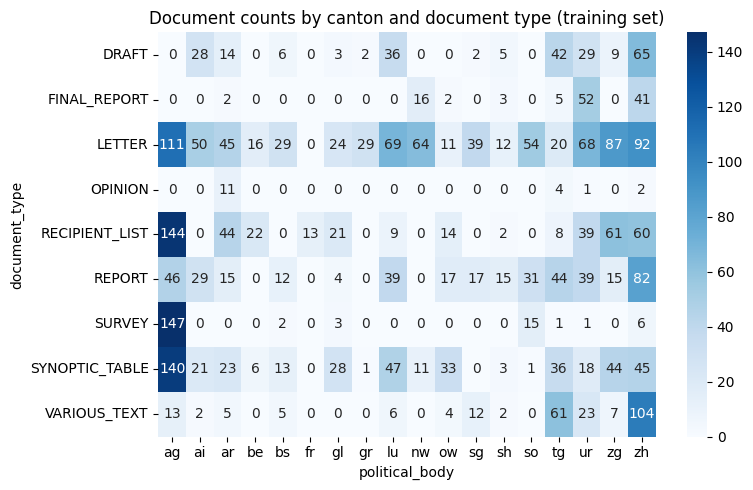

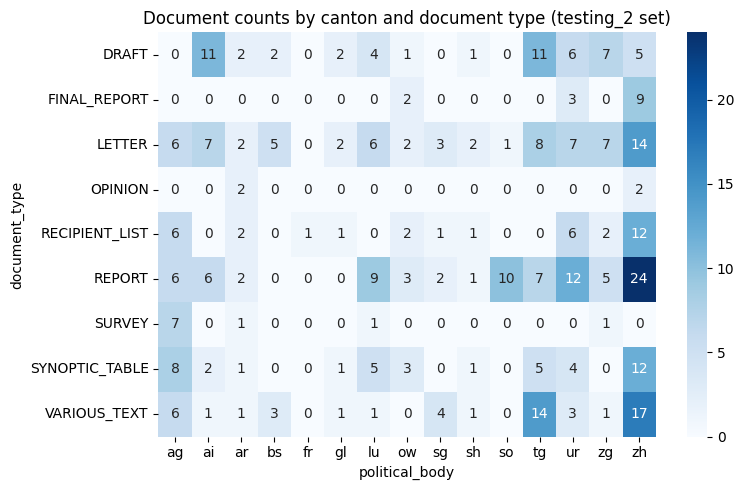

In [15]:
def plot_documents_per_canton(df: pd.DataFrame, set_name: str) -> None:
    df = df[df["political_body"] != "ch"]
    count_matrix = pd.crosstab(df["document_type"], df["political_body"])
    count_matrix = count_matrix.fillna(0)
    plt.figure(figsize=(8, 5))
    sns.heatmap(count_matrix, annot=True, fmt="g", cmap="Blues")
    plt.title(f"Document counts by canton and document type ({set_name} set)")
    plt.tight_layout()
    plt.show()


plot_documents_per_canton(df_input_train, "training")
plot_documents_per_canton(df_input_test_2, "testing_2")

In [16]:
display(df_input_train["document_type_label_source"].value_counts(dropna=False))
display(df_input_train["document_type"].value_counts(dropna=False))

document_type_label_source
fedlex    12356
manual     1713
rule       1218
Name: count, dtype: int64

document_type
LETTER            3302
DRAFT             3092
REPORT            2522
RECIPIENT_LIST    2179
FINAL_REPORT      1843
OPINION            905
VARIOUS_TEXT       651
SYNOPTIC_TABLE     593
SURVEY             200
DECISION             0
LINK                 0
PRESS_RELEASE        0
RESPONSE_FORM        0
Name: count, dtype: int64

In [17]:
display(df_input_test_2["document_type_label_source"].value_counts(dropna=False))
display(df_input_test_2["document_type"].value_counts(dropna=False))

document_type_label_source
manual    368
fedlex      0
rule        0
Name: count, dtype: int64

document_type
REPORT            87
LETTER            72
VARIOUS_TEXT      53
DRAFT             52
SYNOPTIC_TABLE    42
RECIPIENT_LIST    34
FINAL_REPORT      14
SURVEY            10
OPINION            4
DECISION           0
LINK               0
PRESS_RELEASE      0
RESPONSE_FORM      0
Name: count, dtype: int64

In [18]:
mlflow.log_param("train_samples_count", len(df_input_train))
mlflow.log_param("test_1_samples_count", len(df_input_test_1))
mlflow.log_param("test_2_samples_count", len(df_input_test_2))

368

# Data exploration

## Data representation

In [19]:
print("df_input_train labels:")
df_input_train.groupby("document_type_label_source", observed=False)["document_type"].value_counts(dropna=False)

df_input_train labels:


document_type_label_source  document_type 
fedlex                      DRAFT             2851
                            LETTER            2482
                            REPORT            2117
                            RECIPIENT_LIST    1742
                            FINAL_REPORT      1722
                            OPINION            887
                            VARIOUS_TEXT       407
                            SYNOPTIC_TABLE     123
                            SURVEY              25
                            DECISION             0
                            LINK                 0
                            PRESS_RELEASE        0
                            RESPONSE_FORM        0
manual                      REPORT             405
                            LETTER             335
                            VARIOUS_TEXT       244
                            DRAFT              241
                            SYNOPTIC_TABLE     200
                            RECIPIENT_L

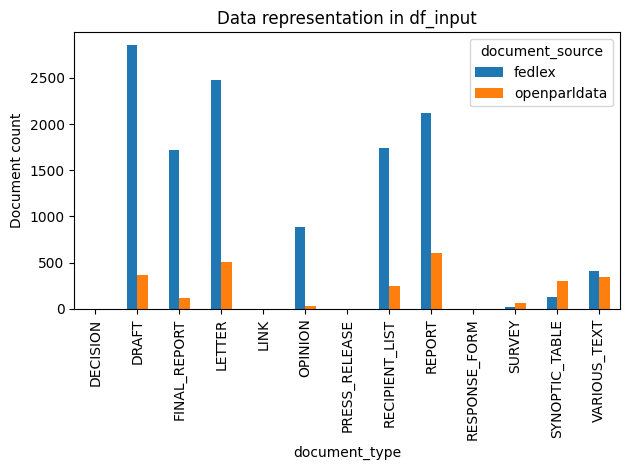

document_source,fedlex,openparldata
document_type,,
DECISION,0,0
DRAFT,2851,363
FINAL_REPORT,1722,112
LETTER,2482,505
LINK,0,0
OPINION,887,27
PRESS_RELEASE,0,0
RECIPIENT_LIST,1742,244
REPORT,2117,600


In [20]:
repr_table = df_input.pivot_table(
    index="document_type", columns="document_source", aggfunc="size", fill_value=0, observed=False
)
display(
    plotting.plot_and_log(
        repr_table.plot,
        "data_representation.png",
        title="Data representation in df_input",
        kind="bar",
        ylabel="Document count",
    )
)
display(repr_table)

## Extra features

In [21]:
print("contains_salutation:")
df_input.pivot_table(
    index="document_type",
    columns="document_source",
    values="contains_salutation",
    aggfunc="mean",
    fill_value=0,
    observed=False,
)

contains_salutation:


document_source,fedlex,openparldata
document_type,,
DRAFT,0.001052,0.000000
FINAL_REPORT,0.002904,0.035714
LETTER,0.985093,0.996040
OPINION,0.749718,0.666667
RECIPIENT_LIST,0.000000,0.000000
REPORT,0.013226,0.048333
SURVEY,0.000000,0.044776
SYNOPTIC_TABLE,0.000000,0.000000
VARIOUS_TEXT,0.014742,0.011429


### Keyword-like features

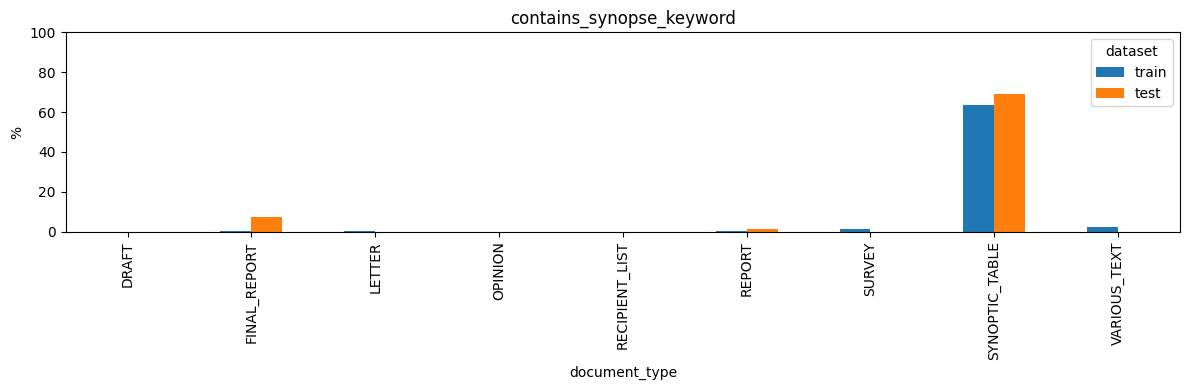

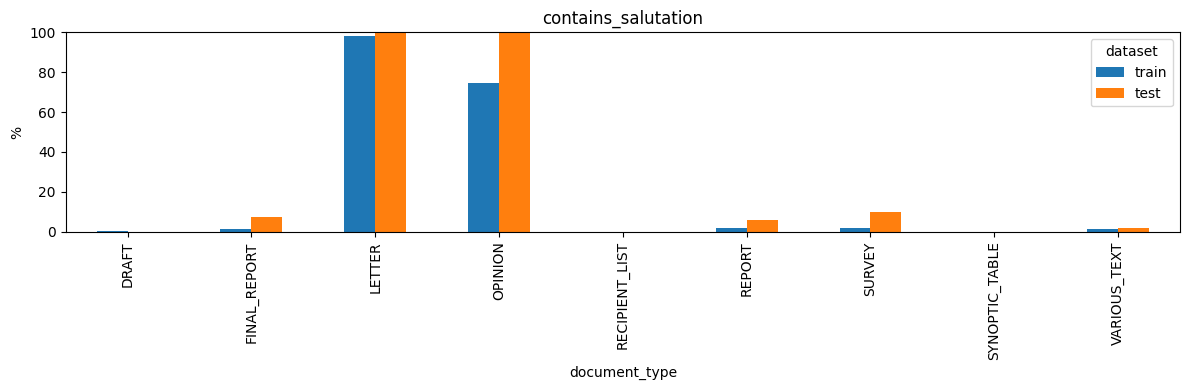

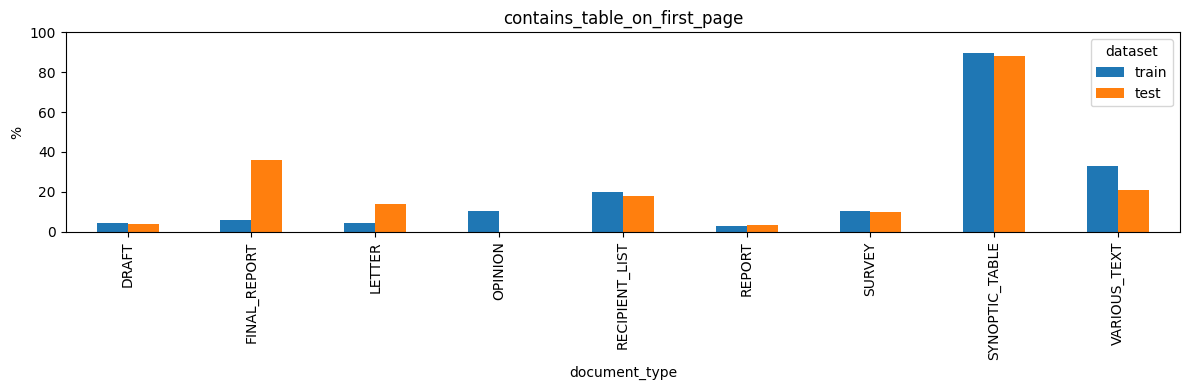

In [22]:
def plot_binary_feature_across_document_types(df_train: pd.DataFrame, df_test: pd.DataFrame, feature_name: str) -> None:
    df = pd.concat(
        [
            df_train[["document_type", feature_name]].assign(dataset="train"),
            df_test[["document_type", feature_name]].assign(dataset="test"),
        ],
        axis=0,
    )
    pivot_table = df.pivot_table(
        index="document_type",
        columns="dataset",
        values=feature_name,
        aggfunc=lambda x: 100 * x.mean(),
        fill_value=0,
        observed=False,
    )
    pivot_table = pivot_table[["train", "test"]]  # Ensure "train" comes first
    pivot_table.plot(
        kind="bar",
        figsize=(12, 4),
        title=feature_name,
        ylabel="%",
        ylim=(0, 100),
    )
    plt.tight_layout()
    plt.show()


plot_binary_feature_across_document_types(df_input_train, df_input_test_2, "contains_synopse_keyword")
plot_binary_feature_across_document_types(df_input_train, df_input_test_2, "contains_salutation")
plot_binary_feature_across_document_types(df_input_train, df_input_test_2, "contains_table_on_first_page")

In [23]:
def plot_feature_distribution_across_document_types(
    df_train: pd.DataFrame, df_test: pd.DataFrame, feature_name: str, clip_y: None | tuple[int, int] = None
) -> None:
    plt.figure(figsize=(14, 5))
    df = pd.concat(
        [
            df_train[["document_type", feature_name]].assign(dataset="train"),
            df_test[["document_type", feature_name]].assign(dataset="test"),
        ],
        axis=0,
    )
    ax = sns.violinplot(
        data=df,
        x="document_type",
        y=feature_name,
        hue="dataset",
        order=sorted(df["document_type"].unique()),
        # inner="box",  # Show boxplot inside violin
        inner=None,  # Show only violin
        split=True,
        linewidth=0.1,
    )
    plt.xticks(rotation=90)
    if clip_y:
        sample = df[feature_name].dropna()
        ax.set_ylim(*np.percentile(sample, clip_y))
        plt.title(f"{feature_name} (clipped to {clip_y[0]}-{clip_y[1]}th percentile)")
    else:
        plt.title(feature_name)
    plt.tight_layout()
    plt.show()

### Page count, aspect ratio

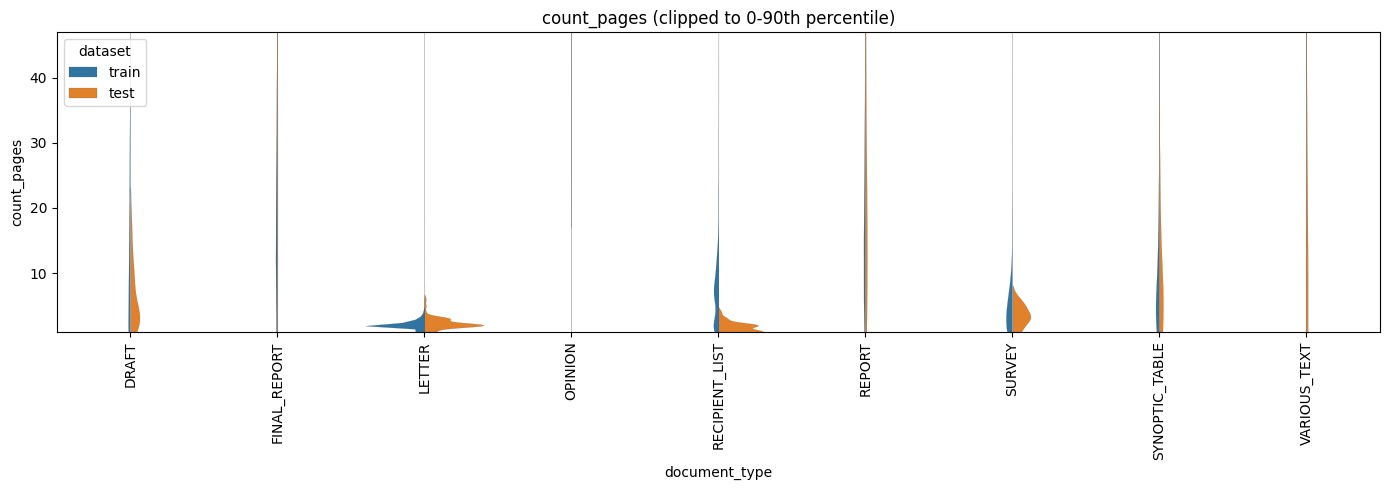

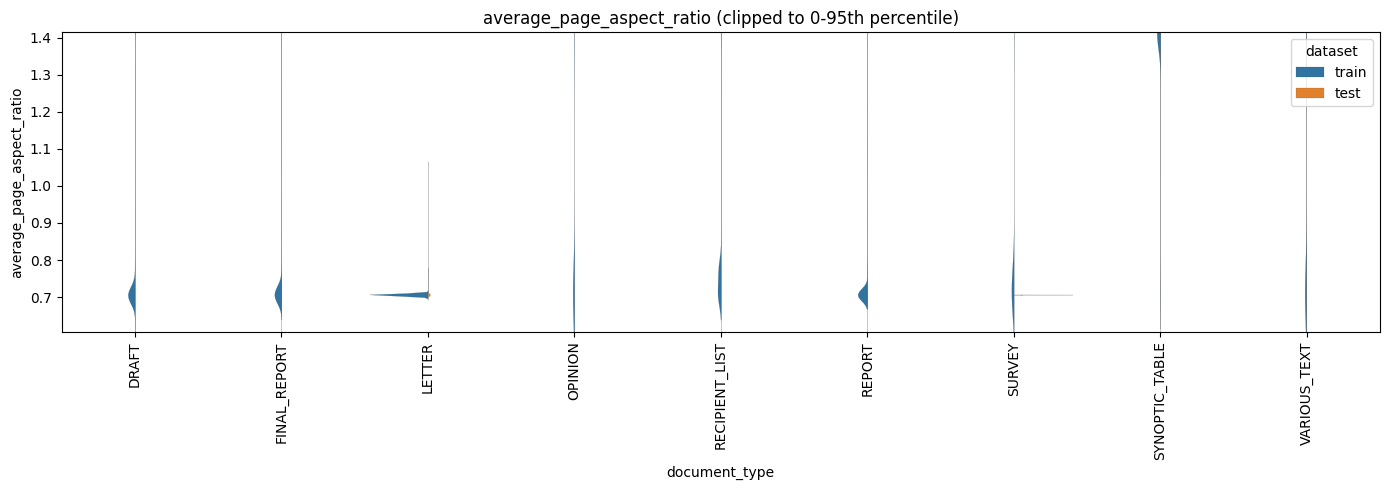

In [24]:
plot_feature_distribution_across_document_types(df_input_train, df_input_test_2, "count_pages", clip_y=(0, 90))
plot_feature_distribution_across_document_types(
    df_input_train, df_input_test_2, "average_page_aspect_ratio", clip_y=(0, 95)
)

In [25]:
pd.concat([df_input_train.assign(dataset="train"), df_input_test_2.assign(dataset="test")], axis=0).pivot_table(
    index="document_type",
    columns="dataset",
    values="count_pages",
    aggfunc=["mean", "std"],
    fill_value=0,
    observed=False,
)

mean                    std            
dataset               test       train       test       train
document_type                                                
DRAFT             6.134615   13.849612   4.631642   45.312928
FINAL_REPORT     55.214286   26.847531  82.410958   43.443176
LETTER            2.263889    2.143549   0.839065    1.381704
OPINION         126.250000  383.471823  38.300348  810.006166
RECIPIENT_LIST    1.676471    7.213401   0.767546    5.533676
REPORT           23.528736   25.060270  27.845437   34.953036
SURVEY            3.400000    4.780000   1.646545    7.343106
SYNOPTIC_TABLE   10.166667   10.846543  13.319556   13.921901
VARIOUS_TEXT     14.301887   20.741935  37.552827  154.296102

In [26]:
pd.concat([df_input_train.assign(dataset="train"), df_input_test_2.assign(dataset="test")], axis=0).pivot_table(
    index="document_type",
    columns="dataset",
    values="average_page_aspect_ratio",
    aggfunc=["mean", "std"],
    fill_value=0,
    observed=False,
)

mean                 std          
dataset             test     train      test     train
document_type                                         
DRAFT           0.734506  0.729390  0.137598  0.112668
FINAL_REPORT    0.901346  0.726203  0.276967  0.101503
LETTER          0.708042  0.707773  0.007735  0.014169
OPINION         0.000000  0.819179  0.000000  0.243591
RECIPIENT_LIST  0.748617  0.766965  0.168906  0.144660
REPORT          0.757566  0.721706  0.124175  0.076839
SURVEY          0.707020  0.768316  0.000147  0.176599
SYNOPTIC_TABLE  1.356818  1.371891  0.188467  0.160847
VARIOUS_TEXT    0.772731  0.875601  0.213529  0.300188

### Tables

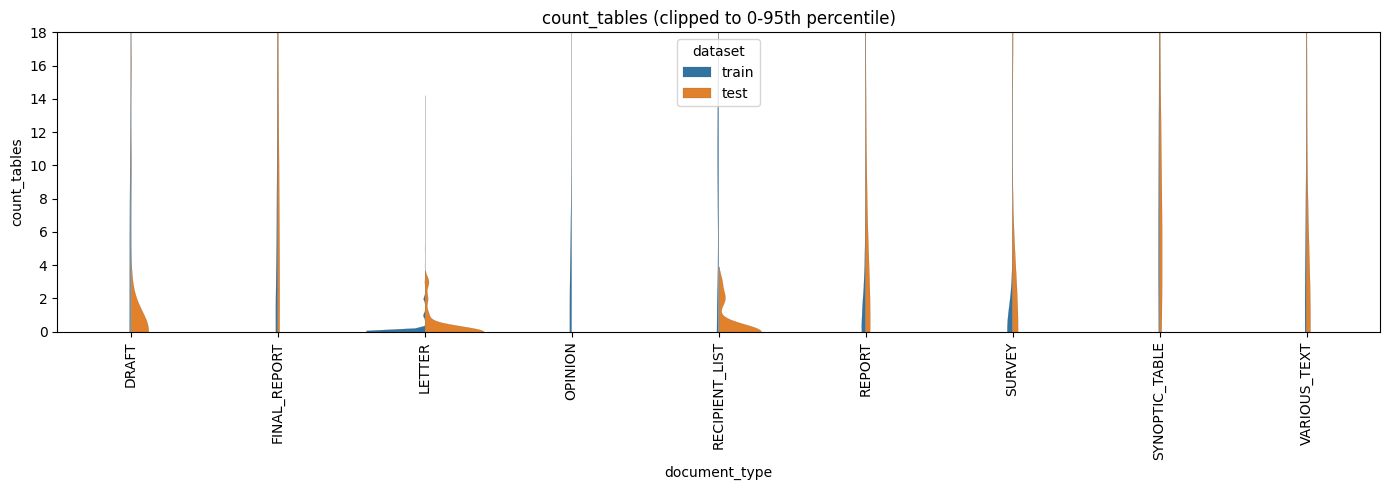

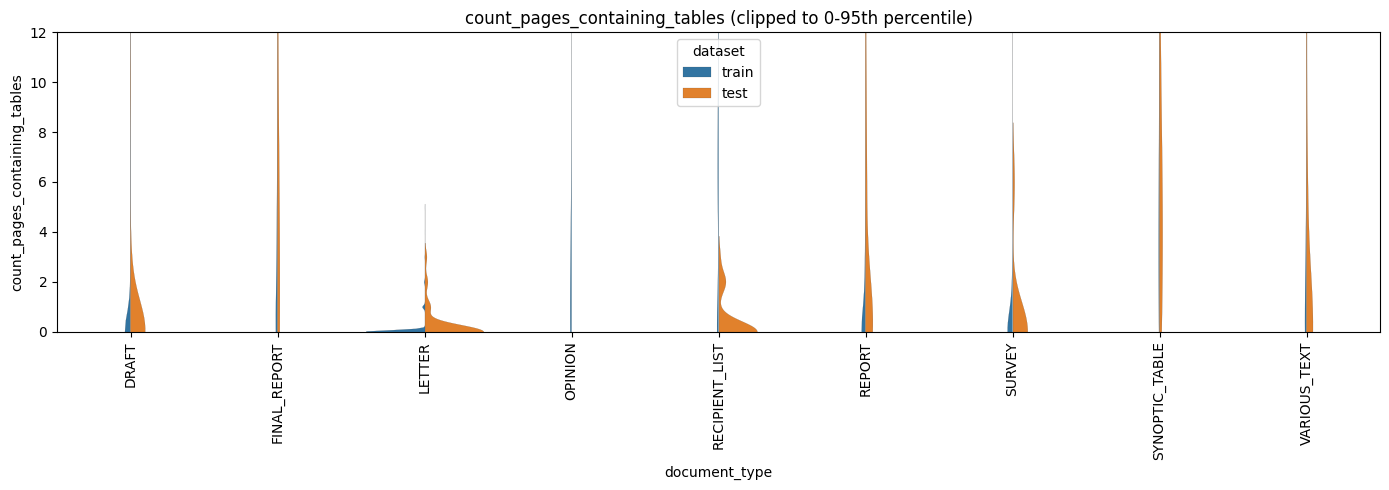

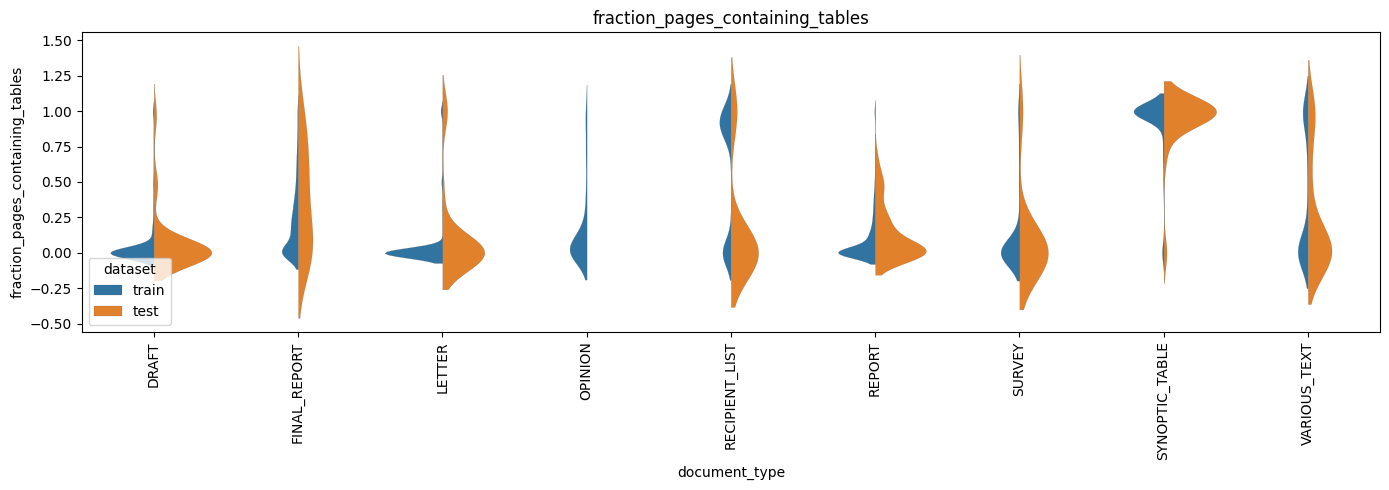

In [27]:
plot_feature_distribution_across_document_types(df_input_train, df_input_test_2, "count_tables", clip_y=(0, 95))
plot_feature_distribution_across_document_types(
    df_input_train, df_input_test_2, "count_pages_containing_tables", clip_y=(0, 95)
)
plot_feature_distribution_across_document_types(df_input_train, df_input_test_2, "fraction_pages_containing_tables")

### Images

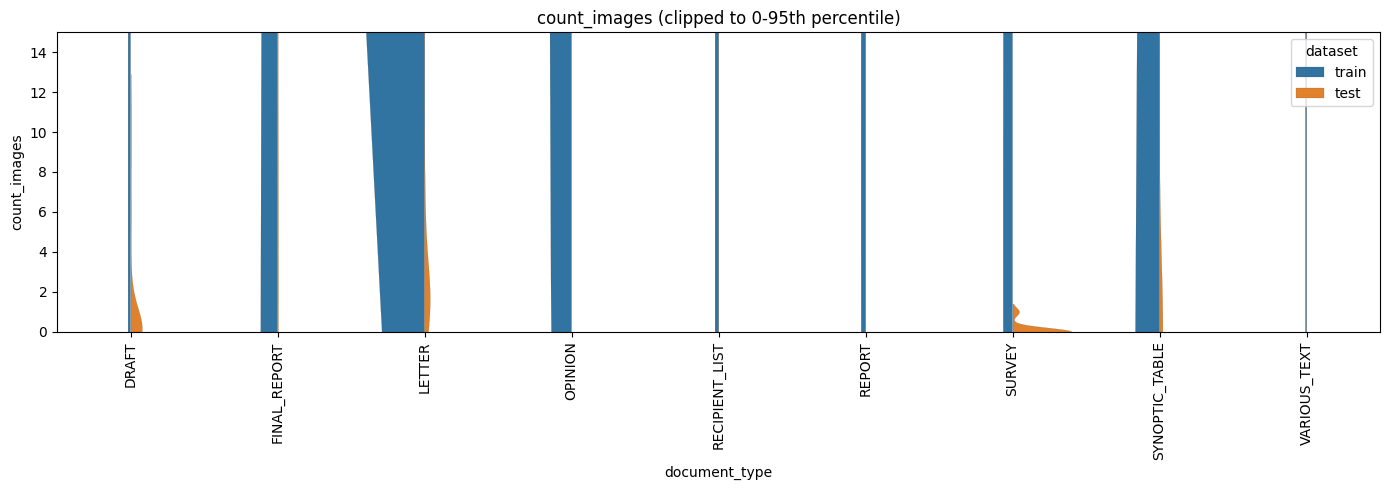

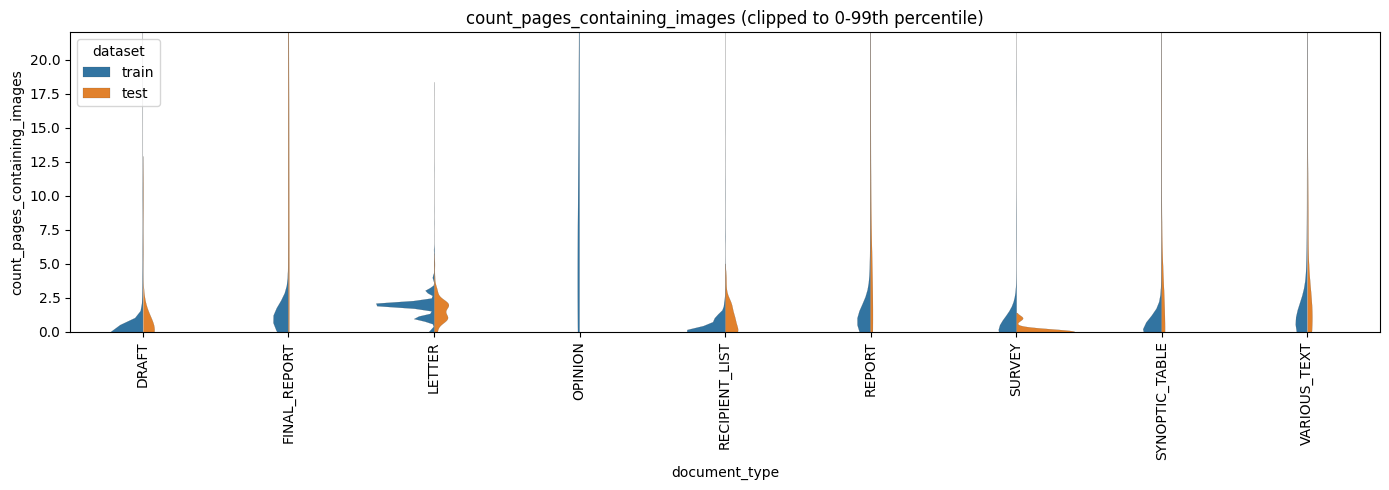

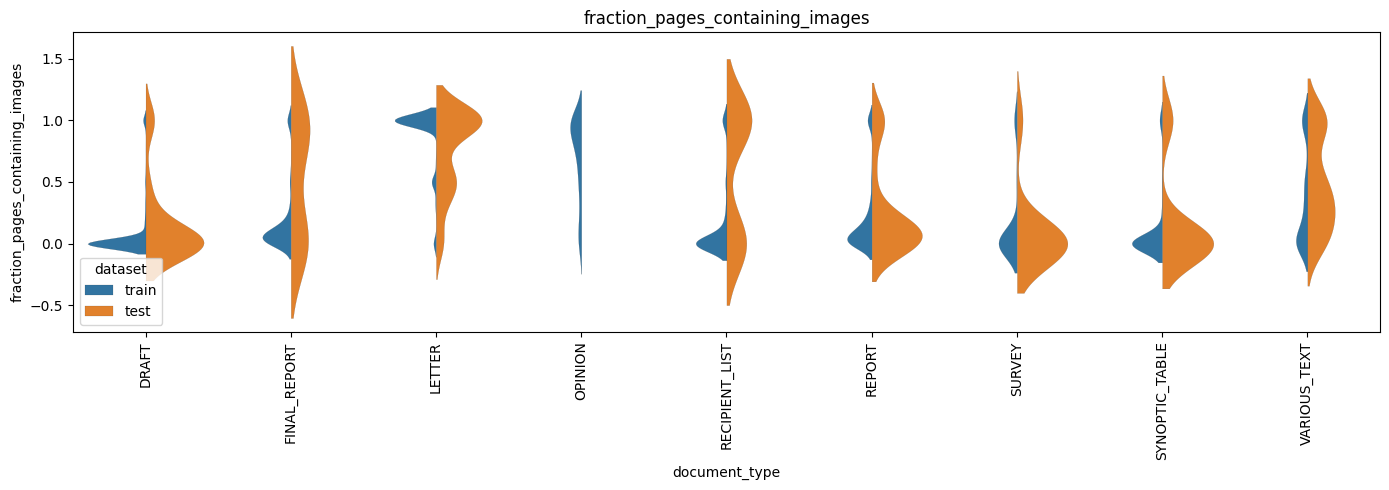

In [28]:
plot_feature_distribution_across_document_types(df_input_train, df_input_test_2, "count_images", clip_y=(0, 95))
plot_feature_distribution_across_document_types(
    df_input_train, df_input_test_2, "count_pages_containing_images", clip_y=(0, 99)
)
plot_feature_distribution_across_document_types(df_input_train, df_input_test_2, "fraction_pages_containing_images")

### Time features

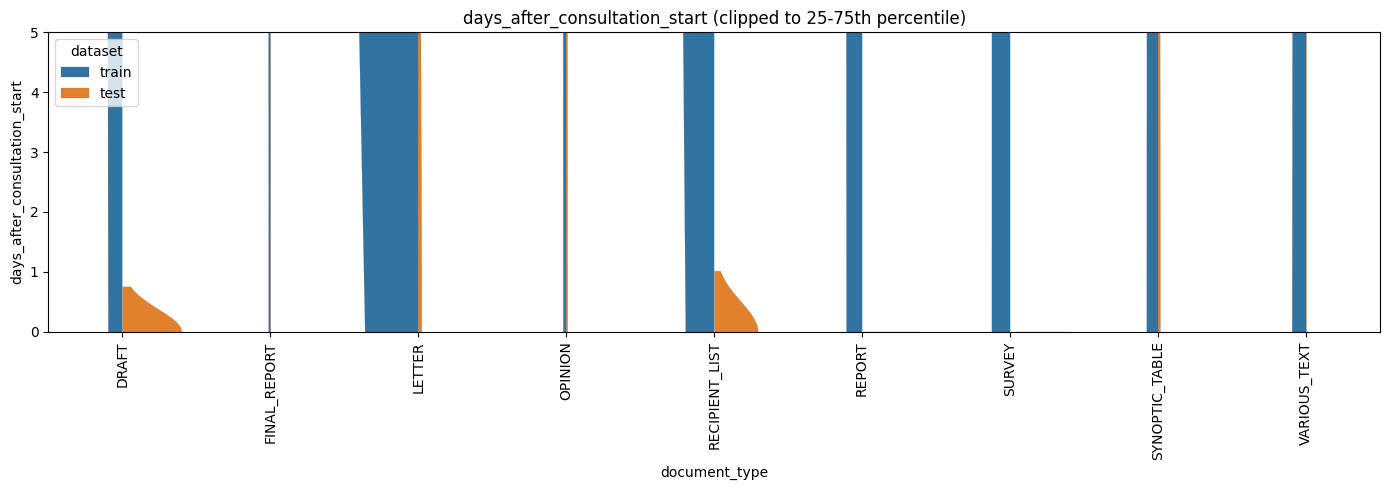

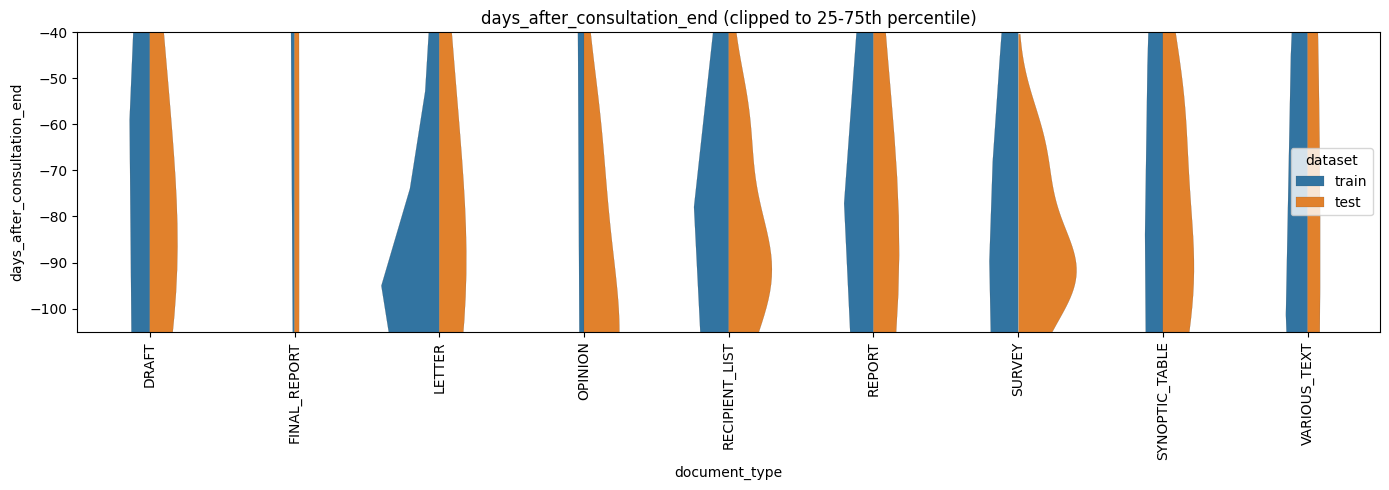

In [29]:
plot_feature_distribution_across_document_types(
    df_input_train,
    df_input_test_2,
    "days_after_consultation_start",
    clip_y=(25, 75),
)
plot_feature_distribution_across_document_types(
    df_input_train,
    df_input_test_2,
    "days_after_consultation_end",
    clip_y=(25, 75),
)

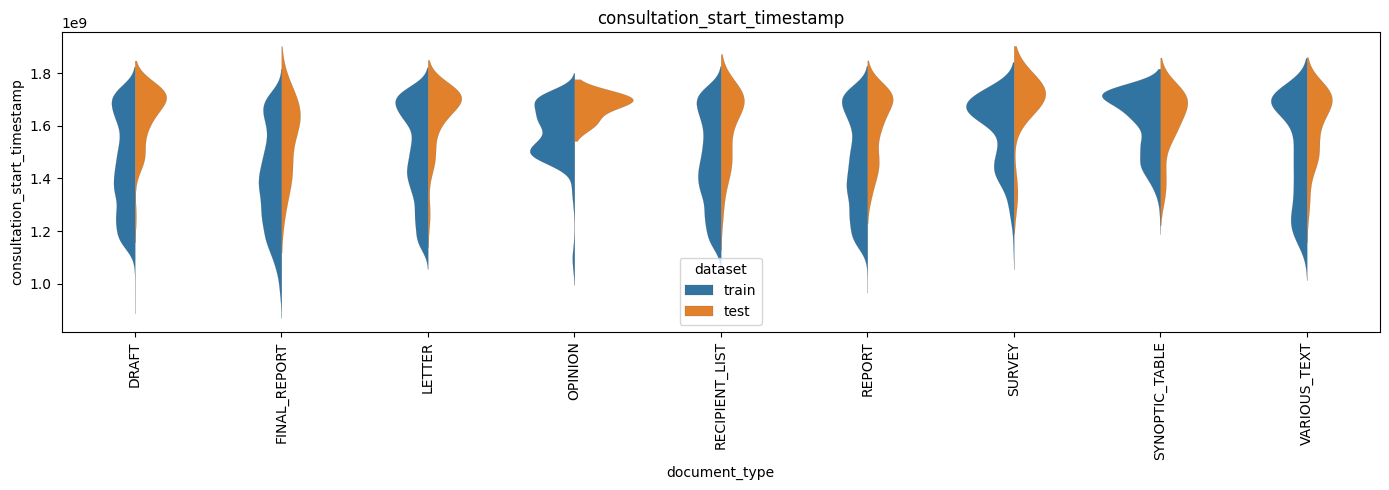

In [30]:
plot_feature_distribution_across_document_types(
    df_input_train,
    df_input_test_2,
    "consultation_start_timestamp",
    # clip_y=(25, 75),
)

# Classification

In [31]:
mlflow.log_param("extra_feature_columns", sorted(demokratis_ml.models.document_types.model.EXTRA_FEATURE_COLUMNS))
mlflow.log_param(
    "extra_categorical_feature_columns", sorted(demokratis_ml.models.document_types.model.EXTRA_CATEGORICAL_COLUMNS)
)

X_train, y_train = demokratis_ml.models.document_types.model.create_matrices(df_input_train, fill_nulls=True)
X_test_1, y_test_1 = demokratis_ml.models.document_types.model.create_matrices(df_input_test_1, fill_nulls=True)
X_test_2, y_test_2 = demokratis_ml.models.document_types.model.create_matrices(df_input_test_2, fill_nulls=True)

print("train", X_train.shape)
print("test_1", X_test_1.shape)
print("test_2", X_test_2.shape)

train (15287, 3084)
test_1 (367, 3084)
test_2 (368, 3084)


## Hyperoptimisation on test_1

In [32]:
def objective_function(params: dict[str, Any]) -> dict[str, Any]:
    logging.info("Training for hyperparameters: %s", params)
    # return {"loss": 1, "status": hyperopt.STATUS_OK}
    classifier = demokratis_ml.models.document_types.model.create_classifier(
        embedding_dimension=embedding_dimension,
        random_state=RANDOM_STATE,
        params=params,
    )
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test_1)
    f1 = sklearn.metrics.f1_score(y_test_1, y_pred, average="weighted", zero_division=np.nan)
    logging.info("F1=%.3f for %s", f1, params)
    return {"loss": -f1, "status": hyperopt.STATUS_OK, "params": params, "f1": f1}


max_evals = 2000

# See https://github.com/hyperopt/hyperopt/issues/253 about the scope.int call
quniform = lambda name, low, high, q: pyll.base.scope.int(hyperopt.hp.quniform(name, low, high, q))  # noqa: E731

search_space = {
    "pca_n_components": quniform("pca_n_components", 50, 400, 10),
    "classifier": hyperopt.hp.choice(
        "classifier",
        [
            # {
            #     "type": "LogisticRegression",
            # },
            {
                "type": "SVC",
                # "C": hyperopt.hp.lognormal("svm_C", 0, 1),
                "C": hyperopt.hp.loguniform("svm_C", np.log(1e-3), np.log(1e3)),
                "gamma": hyperopt.hp.loguniform("svm_gamma", np.log(1e-4), np.log(1e1)),
                "kernel": hyperopt.hp.choice(
                    "svm_kernel",
                    [
                        {"type": "poly", "degree": quniform("svm_poly_degree", 2, 5, 1)},
                        {"type": "rbf"},
                        {"type": "sigmoid"},
                    ],
                ),
                "class_weight": hyperopt.hp.choice("svm_class_weight", ["balanced", None]),
            },
            # We'll try tuning MLP separately
            # {
            #     "type": "MLP",
            #     "hidden_layer_sizes": hyperopt.hp.choice(
            #         "hidden_layer_sizes",
            #         [
            #             (quniform("hidden_layer_size", 64, 512, 32),),
            #             (
            #                 quniform("hidden_layer_size_0", 64, 512, 32),
            #                 quniform("hidden_layer_size_1", 64, 512, 32),
            #             ),
            #         ],
            #     ),
            # },
            # {
            #     "type": "RandomForest",
            #     "n_estimators": quniform("rf_n_estimators", 10, 200, 10),
            #     "criterion": hyperopt.hp.choice("rf_criterion", ["gini", "entropy", "log_loss"]),
            #     "max_depth": hyperopt.hp.choice("rf_max_depth_choice", [None, quniform("rf_max_depth", 5, 50, 1)]),
            #     "min_samples_split": quniform("rf_min_samples_split", 2, 20, 1),
            #     "min_samples_leaf": quniform("rf_min_samples_leaf", 1, 20, 1),
            #     "class_weight": hyperopt.hp.choice("rf_class_weight", ["balanced", None]),
            # },
        ],
    ),
}

if RUN_HYPEROPTIMIZATION:
    assert HYPERPARAMETERS is None, "HYPERPARAMETERS should be pre-defined when running hyperoptimization"
    trials = hyperopt.Trials()
    best_params = hyperopt.fmin(
        objective_function,
        search_space,
        algo=hyperopt.tpe.suggest,
        max_evals=max_evals,
        trials=trials,
    )
    display(best_params)
    assert trials.best_trial
    print(f"F1 {trials.best_trial['result']['f1']:.4f}")
    HYPERPARAMETERS = trials.best_trial["result"]["params"]
else:
    print("Using pre-defined hyperparameters")

Using pre-defined hyperparameters


In [33]:
mlflow.log_param("hyperparameters", HYPERPARAMETERS)

{'classifier': {'type': 'SVC',
  'C': 1.0,
  'class_weight': None,
  'gamma': 'scale',
  'kernel': {'type': 'rbf'}},
 'pca_n_components': 100}

## CV

In [34]:
mlflow.sklearn.autolog()

2025/06/30 21:33:27 WARNING mlflow.utils.autologging_utils: MLflow sklearn autologging is known to be compatible with 0.24.1 <= scikit-learn <= 1.6.1, but the installed version is 1.7.0. If you encounter errors during autologging, try upgrading / downgrading scikit-learn to a compatible version, or try upgrading MLflow.


In [35]:
classifier_cv = demokratis_ml.models.document_types.model.create_classifier(
    embedding_dimension=embedding_dimension,
    params=HYPERPARAMETERS,
    random_state=RANDOM_STATE,
)
classifier_cv

,steps,"[('columntransformer', ...), ('svc', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('embeddings', ...), ('extra_features', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [36]:
cv = sklearn.model_selection.StratifiedKFold(
    n_splits=CV_FOLDS,
    shuffle=True,
    random_state=RANDOM_STATE,
)


def explained_variance_scorer(pipeline: sklearn.pipeline.Pipeline, X: Any, y: Any = None) -> np.float64:
    pca = demokratis_ml.models.document_types.model.get_pca_step(pipeline)
    if pca is None:
        return np.nan
    explained_variance = np.sum(pca.explained_variance_ratio_)
    return explained_variance


scoring = {
    "precision": "precision_weighted",
    "recall": "recall_weighted",
    "f1": "f1_weighted",
    "pca_explained_variance": explained_variance_scorer,
    "accuracy": "accuracy",
    "top_k_accuracy": "top_k_accuracy",
    # "top_k_accuracy": sklearn.metrics.make_scorer(sklearn.metrics.top_k_accuracy_score, k=3),
}

print("cross_validate...")
cv_scores = sklearn.model_selection.cross_validate(
    classifier_cv, X=X_train, y=y_train, cv=cv, scoring=scoring, verbose=1, n_jobs=-1
)
display(cv_scores)

print("\ncross_val_predict...")
y_cv_predicted = sklearn.model_selection.cross_val_predict(
    classifier_cv, X=X_train, y=y_train, cv=cv, verbose=2, n_jobs=-1
)

cross_validate...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
/Users/vita/.pyenv/versions/3.12.1/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Users/vita/.pyenv/versions/3.12.1/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Users/vita/.pyenv/versions/3.12.1/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_res

{'fit_time': array([13.13966107, 12.65288806, 13.426893  , 12.62651515, 13.2929368 ]),
 'score_time': array([2.4973309 , 2.42844701, 2.51040196, 2.44863892, 2.47206092]),
 'test_precision': array([0.94085534, 0.95441727, 0.95334677, 0.95201749, 0.94826193]),
 'test_recall': array([0.94506213, 0.95552649, 0.95420347, 0.95322211, 0.94962381]),
 'test_f1': array([0.94041074, 0.9537506 , 0.95282972, 0.95163278, 0.94736993]),
 'test_pca_explained_variance': array([0.65736407, 0.65687239, 0.65677911, 0.65726745, 0.6577155 ]),
 'test_accuracy': array([0.94506213, 0.95552649, 0.95420347, 0.95322211, 0.94962381]),
 'test_top_k_accuracy': array([0.98201439, 0.98364944, 0.98593392, 0.98135427, 0.98495257])}

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.



cross_val_predict...


/Users/vita/.pyenv/versions/3.12.1/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Users/vita/.pyenv/versions/3.12.1/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Users/vita/.pyenv/versions/3.12.1/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from usi

In [37]:
utils.log_metrics(
    **{k.replace("test_", "cv_"): np.round(np.mean(v), 4) for k, v in cv_scores.items() if k.startswith("test_")}
)

{'cv_accuracy': 0.9515,
 'cv_f1': 0.9492,
 'cv_pca_explained_variance': 0.6572,
 'cv_precision': 0.9498,
 'cv_recall': 0.9515,
 'cv_top_k_accuracy': 0.9836}


                precision    recall  f1-score   support

         DRAFT       0.91      0.95      0.93      3092
  FINAL_REPORT       0.99      0.97      0.98      1843
        LETTER       0.99      1.00      0.99      3302
       OPINION       0.98      0.96      0.97       905
RECIPIENT_LIST       0.99      1.00      1.00      2179
        REPORT       0.92      0.98      0.95      2522
        SURVEY       0.96      0.87      0.91       200
SYNOPTIC_TABLE       0.89      0.80      0.84       593
  VARIOUS_TEXT       0.78      0.54      0.64       651

      accuracy                           0.95     15287
     macro avg       0.94      0.90      0.91     15287
  weighted avg       0.95      0.95      0.95     15287



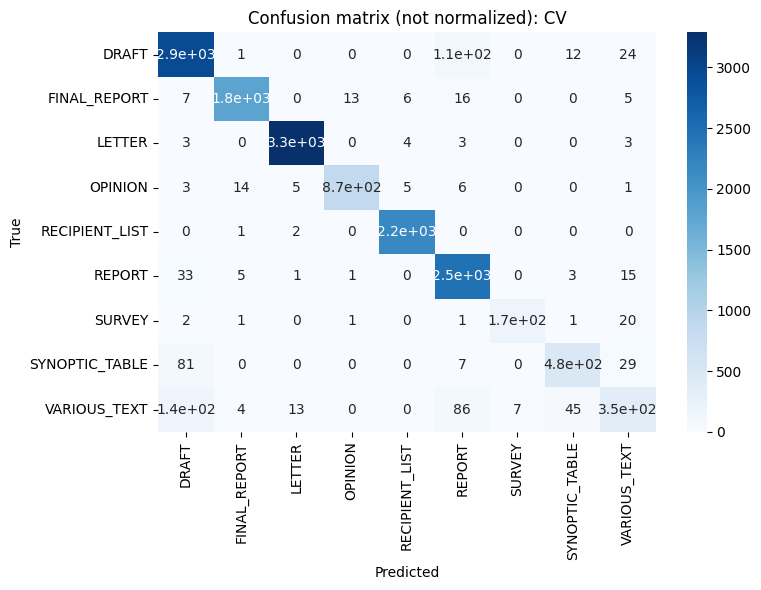

In [38]:
report = sklearn.metrics.classification_report(y_train, y_cv_predicted, zero_division=np.nan)
mlflow.log_text(report, "cv_classification_report.txt")
print(report)
cm = plotting.plot_confusion_matrix_heatmap(y_train, y_cv_predicted, title="CV")
mlflow.log_figure(cm, "cv_confusion_matrix.png")
display(cm)

## Training

In [39]:
classifier_test = demokratis_ml.models.document_types.model.create_classifier(
    embedding_dimension=embedding_dimension,
    params=HYPERPARAMETERS,
    random_state=RANDOM_STATE,
)
classifier_test.fit(X_train, y_train)

2025/06/30 21:34:03 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/06/30 21:34:55 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


,steps,"[('columntransformer', ...), ('svc', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('embeddings', ...), ('extra_features', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## Evaluation on test_2

                precision    recall  f1-score   support

         DRAFT       0.88      0.88      0.88        52
  FINAL_REPORT       0.92      0.79      0.85        14
        LETTER       0.97      0.99      0.98        72
       OPINION       0.80      1.00      0.89         4
RECIPIENT_LIST       1.00      1.00      1.00        34
        REPORT       0.81      0.94      0.87        87
        SURVEY       1.00      0.90      0.95        10
SYNOPTIC_TABLE       0.90      0.86      0.88        42
  VARIOUS_TEXT       0.93      0.74      0.82        53

      accuracy                           0.90       368
     macro avg       0.91      0.90      0.90       368
  weighted avg       0.91      0.90      0.90       368



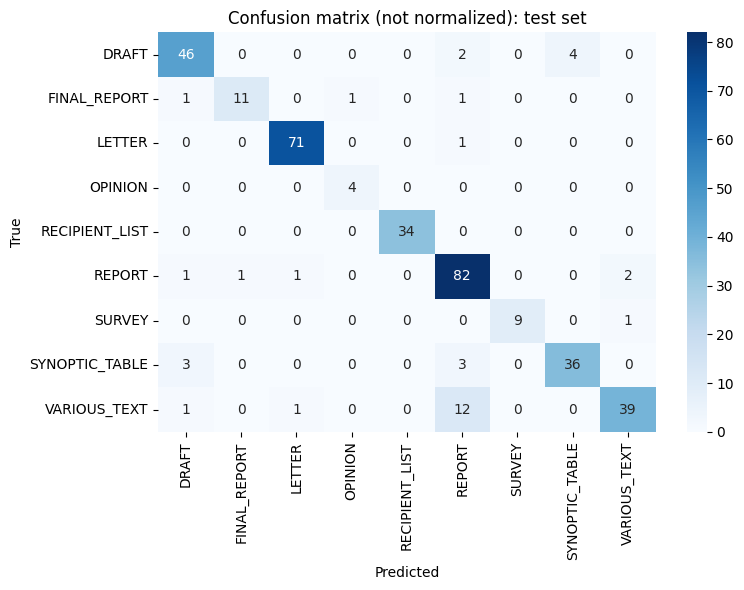

{'test_accuracy': 0.9022,
 'test_f1': 0.9013,
 'test_precision': 0.9068,
 'test_recall': 0.9022}


In [40]:
y_test_2_predicted = classifier_test.predict(X_test_2)

# Classification report
report = sklearn.metrics.classification_report(
    y_test_2,
    y_test_2_predicted,
    zero_division=np.nan,
)
mlflow.log_text(report, "test_classification_report.txt")
print(report)

# Confusion matrix
cm = plotting.plot_confusion_matrix_heatmap(y_test_2, y_test_2_predicted, title="test set")
mlflow.log_figure(cm, "test_confusion_matrix.png")
display(cm)

# Metrics
test_metrics = sklearn.metrics.precision_recall_fscore_support(
    y_test_2,
    y_test_2_predicted,
    average="weighted",
    zero_division=np.nan,
)
utils.log_metrics(
    test_precision=test_metrics[0],
    test_recall=test_metrics[1],
    test_f1=test_metrics[2],
    test_accuracy=sklearn.metrics.accuracy_score(y_test_2, y_test_2_predicted),
    # test_top_k_accuracy=sklearn.metrics.top_k_accuracy_score(y_test_2, classifier_test_2.predict_proba(X_test_2)),
)

### Feature importance

In [41]:
# forest = classifier_test.named_steps["randomforestclassifier"]
# pca = demokratis_ml.models.document_types.model.get_pca_step(classifier_test)
# assert pca is not None

# forest_importances = pd.Series(
#     forest.feature_importances_,
#     index=(
#         [f"embedding_{i:02d}" for i in range(pca.n_components)]
#         + list(demokratis_ml.models.document_types.model.EXTRA_FEATURE_COLUMNS)
#         + list(demokratis_ml.models.document_types.model.EXTRA_CATEGORICAL_COLUMNS)
#     ),
# )
# std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

# fig, ax = plt.subplots(figsize=(12, 2.5 * np.log(len(forest_importances))))
# forest_importances.plot.barh(xerr=std, ax=ax)
# ax.invert_yaxis()  # start with embeddings at the top
# ax.set_title("Feature importances using MDI")
# ax.set_ylabel("Mean decrease in impurity")
# fig.tight_layout()

# mlflow.log_figure(fig, "feature_importance_mdi.png")

### Results per canton

In [42]:
df_eval = df_input_test_2.copy()
df_eval["document_type_predicted"] = y_test_2_predicted

for canton_code, df_canton in df_eval.groupby("political_body", observed=False):
    # Skip the "ch" political_body, which is the federal level and not a canton
    if canton_code == "ch":
        continue
    print(f"\n{'-' * 60}\n{canton_code}\n{'-' * 60}")
    if df_canton.empty:
        print("No data")
    else:
        report = sklearn.metrics.classification_report(
            df_canton["document_type"], df_canton["document_type_predicted"], zero_division=np.nan
        )
        print(report)


------------------------------------------------------------
ag
------------------------------------------------------------
                precision    recall  f1-score   support

         DRAFT       0.00       nan      0.00         0
        LETTER       0.86      1.00      0.92         6
RECIPIENT_LIST       1.00      1.00      1.00         6
        REPORT       0.50      0.83      0.62         6
        SURVEY       1.00      0.86      0.92         7
SYNOPTIC_TABLE       1.00      0.88      0.93         8
  VARIOUS_TEXT       0.50      0.17      0.25         6

      accuracy                           0.79        39
     macro avg       0.69      0.79      0.66        39
  weighted avg       0.82      0.79      0.79        39


------------------------------------------------------------
ai
------------------------------------------------------------
                precision    recall  f1-score   support

         DRAFT       1.00      0.91      0.95        11
        LETTER  

## Comparison to the rule-based model

In [43]:
# We must erase the true labels first because the rule-based model doesn't overwrite existing labels.
_df = df_input_test_2.copy()
_df.loc[:, "document_type"] = None
# Explicit class-merging step is needed because the rule-based model may output any class.
y_test_predicted_rules = demokratis_ml.models.document_types.preprocessing.merge_classes(
    document_title_rule_model.predict(_df),
    demokratis_ml.models.document_types.preprocessing.MERGE_CLASSES,
)

INFO document_title_rule_model: 0.00% of documents already have labels
WARNING document_title_rule_model: Labelled 0.00% by rule: canton=<any>, title^=adressliste => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 3.53% by rule: canton=<any>, title^=adressatenliste => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 0.27% by rule: canton=<any>, title^=adressatenverzeichnis => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 0.82% by rule: canton=<any>, title^=vernehmlassungsadressaten => type=RECIPIENT_LIST
WARNING document_title_rule_model: Labelled 0.00% by rule: canton=<any>, title^=vernehmlassungsadressen => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 0.27% by rule: canton=<any>, title^=verzeichnis der anhörungsadressaten => type=RECIPIENT_LIST
WARNING document_title_rule_model: Labelled 0.00% by rule: canton=<any>, title^=liste der konsultationsadressatinnen und konsultationsadressaten => type=RECIPIENT_LIST
INFO document_title

                precision    recall  f1-score   support

         DRAFT       0.71      1.00      0.83        42
  FINAL_REPORT       1.00      0.50      0.67         4
        LETTER       1.00      1.00      1.00        71
RECIPIENT_LIST       1.00      1.00      1.00        25
        REPORT       0.91      0.81      0.86        79
        SURVEY       1.00      1.00      1.00        10
SYNOPTIC_TABLE       1.00      0.91      0.96        35
  VARIOUS_TEXT       0.95      0.83      0.88        23

      accuracy                           0.92       289
     macro avg       0.95      0.88      0.90       289
  weighted avg       0.93      0.92      0.92       289



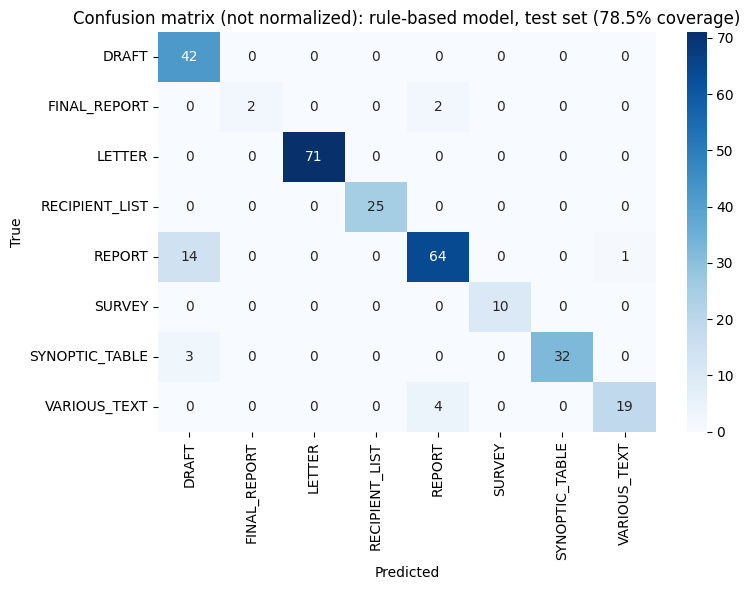

In [44]:
_y_true = y_test_2[y_test_predicted_rules.notna()]
_y_predicted = y_test_predicted_rules[y_test_predicted_rules.notna()]

coverage = np.mean(y_test_predicted_rules.notna())
print(sklearn.metrics.classification_report(_y_true, _y_predicted, zero_division=np.nan))
plotting.plot_confusion_matrix_heatmap(
    _y_true,
    _y_predicted,
    title=f"rule-based model, test set ({100 * coverage:.1f}% coverage)",
    # normalize="true",
)

## Display all test samples & predictions

In [45]:
df_display = df_input_test_2.copy()
df_display["prediction_rule"] = y_test_predicted_rules
df_display["prediction_ml"] = y_test_2_predicted

df_display[
    [
        "document_id",
        "political_body",
        "consultation_url",
        "document_source_url",
        "document_title",
        "document_type",
        "prediction_rule",
        "prediction_ml",
    ]
].style.format(
    {
        "consultation_url": lambda x: f'<a href="{x}">vnl</a>',
        "document_source_url": lambda x: f'<a href="{x}">doc</a>',
    }
).apply(
    lambda row: [
        f"color: {'green' if row[col] == row['document_type'] else 'red'}"
        if col in {"prediction_rule", "prediction_ml"}
        else ""
        for col in row.index
    ],
    axis=1,
).set_table_styles([{"selector": "th,td", "props": [("text-align", "left")]}])

,document_id,political_body,consultation_url,document_source_url,document_title,document_type,prediction_rule,prediction_ml
38690,38719,ag,vnl,doc,Anhörungsbericht,REPORT,REPORT,REPORT
39537,39707,ai,vnl,doc,Entwurf Grossratsbeschluss zur Revision der SchV,DRAFT,DRAFT,DRAFT
42054,42689,gl,vnl,doc,Vorlage EG BBG 2016,DRAFT,nan,DRAFT
53536,55490,ag,vnl,doc,Beilage 3 zum Anhörungsbericht,VARIOUS_TEXT,nan,REPORT
39702,39872,ar,vnl,doc,Beilage 1 Abzüge für Versicherungsprämien und Sparzinsen,VARIOUS_TEXT,nan,VARIOUS_TEXT
44967,45713,tg,vnl,doc,Entwurf Planungs- und Baugesetz,DRAFT,DRAFT,DRAFT
46909,47903,zh,vnl,doc,Erläuterungen Zulassung Impfungen Apotheken,REPORT,REPORT,REPORT
50876,52565,zh,vnl,doc,Einladungsschreiben,LETTER,LETTER,LETTER
43437,44159,ow,vnl,doc,Einladungsschreiben,LETTER,LETTER,LETTER
47379,48384,zh,vnl,doc,Erläuterungsbericht und Synopse PBG,REPORT,REPORT,REPORT


***

# End run

In [46]:
# mlflow.sklearn.log_model(
#     classifier_test,
#     artifact_path="model",
#     registered_model_name="document_type_classifier",
# )

In [47]:
mlflow.end_run()

🏃 View run spiffy-seal-793 at: https://mlflow.ml1.demokratis.ch/#/experiments/4/runs/a7f2bb8cb5444c5d85d1d826f4f7c8d0
🧪 View experiment at: https://mlflow.ml1.demokratis.ch/#/experiments/4
